In [1]:
from collections import defaultdict
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from BoT_IoT_config import BoT_IoT_Config

SOURCE_COL = BoT_IoT_Config.SOURCE_IP_COL_NAME
DESTINATION_COL = BoT_IoT_Config.DESTINATION_IP_COL_NAME
LABEL_COL = BoT_IoT_Config.IS_ATTACK_COL_NAME
CATEGORY_COL = BoT_IoT_Config.ATTACK_CLASS_COL_NAME

BENIGN_CLASS_NAME = BoT_IoT_Config.BENIGN_CLASS_NAME
TIME_COL = BoT_IoT_Config.TIME_COL_NAMES


93
defaultdict(<class 'list'>, {'Reconnaissance': [2375733, 451694, 414859, 412209, 3111, 3860, 2969, 3658], 'Normal': [2, 0, 5, 37, 8, 12, 3, 59, 13, 60, 0, 4, 4, 1, 1, 7, 3, 3, 2, 3, 6, 1, 1, 4, 3, 4, 0, 10, 55, 0, 0, 0, 8, 4, 4, 0, 0, 2, 3, 0, 1, 2, 3, 3, 6, 3, 1, 4, 4, 1, 2, 3, 2, 2, 2, 2, 2, 1, 2, 3, 2, 2, 2, 2, 4, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 4, 2, 2, 2, 1]})


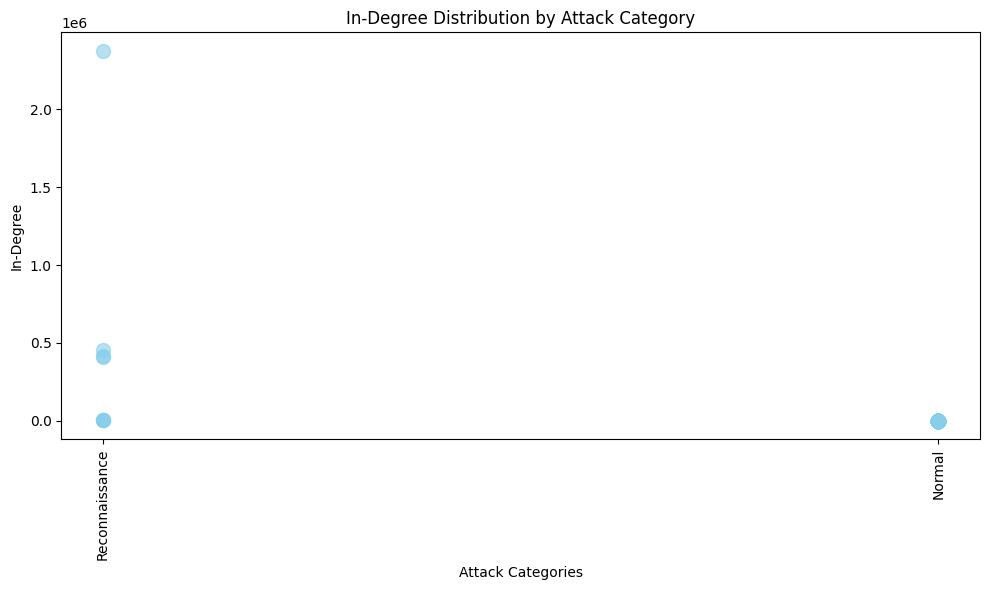

In [2]:

df = pd.read_csv('./All/all_raw.csv')

G = nx.MultiDiGraph()

# G.add_nodes_from(df[SOURCE_COL].unique())
# G.add_nodes_from(df[DESTINATION_COL].unique())

G.add_edges_from(
    (row[SOURCE_COL], row[DESTINATION_COL], {'attack_category': row[CATEGORY_COL], 'label': row[LABEL_COL]})
    for _, row in df.iterrows()
)

category_in_degrees = defaultdict(list)

for node in G.nodes:
    in_edges = G.in_edges(node, data=True)
    out_edges = G.out_edges(node, data=True)

    attacker = False
    for _, _, data in out_edges:
        if data.get('label') == 1:  # Check if the edge is labeled as an attack
            attacker = True
            category = data.get('attack_category', 'Unknown')
            category_in_degrees[category].append(len(in_edges))
            break

    if not attacker:
        category_in_degrees[BENIGN_CLASS_NAME].append(len(in_edges))

plt.figure(figsize=(10, 6))

print(len(G.nodes))
print(category_in_degrees)

# Prepare data for scatter plot
categories = []
in_degrees = []

for category, degrees in category_in_degrees.items():
    categories.extend([category] * len(degrees))
    in_degrees.extend(degrees)

plt.scatter(categories, in_degrees, color='skyblue', s=100, alpha=0.6)
plt.xlabel('Attack Categories')
plt.ylabel('In-Degree')
plt.title('In-Degree Distribution by Attack Category')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [3]:
def print_attack_node_and_their_in_traffic(df):

    # Strip whitespaces 
    df.columns = df.columns.str.strip()
    
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

    # Find all attacker nodes
    attacker_nodes = df[df[CATEGORY_COL] != BENIGN_CLASS_NAME][SOURCE_COL].unique()
    print("Attacker Nodes:", attacker_nodes)

    # Find all traffic where attacker node is the destination
    directed_to_attacker_traffic = df[df[DESTINATION_COL].isin(attacker_nodes)]

    # Find all nodes that have directed traffic to attacker nodes
    source_node_to_attacker = directed_to_attacker_traffic[SOURCE_COL].unique()
    print("Source Node to Attacker:", source_node_to_attacker)

    attack_directed_to_attacker_traffic = directed_to_attacker_traffic[directed_to_attacker_traffic[CATEGORY_COL] != BENIGN_CLASS_NAME]
    
    print("Example Attacks on Attacker Nodes:", attack_directed_to_attacker_traffic.groupby(SOURCE_COL).head(1))

    print("Source Node to Attacker with Attack Traffic:", attack_directed_to_attacker_traffic[SOURCE_COL].unique())

    print("No of Attacks on Attacker Nodes:", len(attack_directed_to_attacker_traffic))

    directed_to_attacker_traffic_attack_type = directed_to_attacker_traffic[CATEGORY_COL].unique()
    print("Traffic to Attacker Nodes Attack Type:", directed_to_attacker_traffic_attack_type)

print_attack_node_and_their_in_traffic(df)

/tmp/ipykernel_412459/1409605082.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


Attacker Nodes: ['192.168.100.150' '192.168.100.149' '192.168.100.148' '192.168.100.147'
 '192.168.100.3' '192.168.100.5' '192.168.100.6' '192.168.100.7']
Source Node to Attacker: ['192.168.100.46' '192.168.100.7' '192.168.100.6' '192.168.100.5'
 '192.168.100.1' '192.168.100.4' '192.168.100.150' '192.168.100.149'
 '192.168.100.148' '192.168.100.147' '192.168.100.3' '192.168.100.55']
Example Attacks on Attacker Nodes:        pkSeqID         stime flgs  flgs_number proto  proto_number  \
16     3599352  1.526344e+09    e            1   arp             2   
18     3599355  1.526344e+09    e            1   arp             2   
20     3599362  1.526344e+09    e            1   arp             2   
24     3599363  1.526344e+09    e            1   arp             2   
891    3596144  1.526344e+09    e            1   tcp             1   
13935  3609139  1.526345e+09    e            1   udp             3   
82032  3585748  1.526876e+09    e            1   arp             2   
86788  3590502  1.5

In [4]:
attack_traffic = df[df[LABEL_COL] == 1]

# Group attack traffic by destination IP and attack category, and count occurrences
attack_traffic_grouped = attack_traffic.groupby([DESTINATION_COL, CATEGORY_COL])

# Print the number of rows in the grouped DataFrame
print(attack_traffic_grouped.size())

daddr            category      
192.168.100.147  DDoS                 1339
                 DoS                    12
                 Reconnaissance       2306
192.168.100.148  DDoS                  249
                 DoS                   290
                 Reconnaissance       2429
192.168.100.149  DDoS                  582
                 DoS                    89
                 Reconnaissance       2414
                 Theft                  25
192.168.100.150  DDoS                 1316
                 DoS                   134
                 Reconnaissance       2383
                 Theft                  26
192.168.100.3    DDoS              1923138
                 DoS                411572
                 Reconnaissance      40972
                 Theft                  27
192.168.100.5    DoS                420310
                 Reconnaissance      31368
192.168.100.6    DoS                407490
                 Reconnaissance       4718
                 Theft

In [5]:
import os

df = pd.read_csv('./All/all_raw.csv', header=0)

# Get nodes that are both attackers and victims
def get_attacker_and_victim_nodes(df):
    # Strip whitespaces from column names
    df.columns = df.columns.str.strip()

    attack_traffic = df[df[CATEGORY_COL] != BoT_IoT_Config.BENIGN_CLASS_NAME]
    
    # Get unique attacker nodes
    attacker_nodes = attack_traffic[BoT_IoT_Config.SOURCE_IP_COL_NAME].unique()
    
    # Get unique victim nodes (nodes that are destinations)
    victim_nodes = attack_traffic[BoT_IoT_Config.DESTINATION_IP_COL_NAME].unique()
    
    # Find intersection of attacker and victim nodes
    both_attacker_and_victim = set(attacker_nodes) & set(victim_nodes)
    
    print("Attacker: ", attacker_nodes)
    print("Victim: ", victim_nodes)
    print("Nodes that are both attackers and victims:", both_attacker_and_victim)

    return (attacker_nodes, victim_nodes)

# Directory containing the CSV files
directory = './Raw'

# Iterate through all CSV files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory, filename)
        print(f"Processing file: {filename}")
        
        # Read the CSV file
        file_df = pd.read_csv(file_path, header=0)
        get_attacker_and_victim_nodes(file_df)
        
        # Run the function
        # get_attacker_and_victim_nodes(file_df)
        min_time = file_df[TIME_COL[0]].min()
        max_time = file_df[TIME_COL[0]].max()
        print(f"Min/Max Start Timestamp in {filename}: {min_time}/{max_time}")
        
        min_time = file_df[TIME_COL[1]].min()
        max_time = file_df[TIME_COL[1]].max()
        print(f"Min/Max End Timestamp in {filename}: {min_time}/{max_time}")

get_attacker_and_victim_nodes(df)

Processing file: UNSW_2018_IoT_Botnet_Full5pc_1.csv


/tmp/ipykernel_412459/3986391906.py:37: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  file_df = pd.read_csv(file_path, header=0)


Attacker:  ['192.168.100.147' '192.168.100.7' '192.168.100.148' '192.168.100.6'
 '192.168.100.149' '192.168.100.150' '192.168.100.5' '192.168.100.3']
Victim:  ['192.168.100.7' '192.168.100.147' '192.168.100.6' '192.168.100.148'
 '192.168.100.5' '192.168.100.3' '192.168.100.149' '192.168.100.150']
Nodes that are both attackers and victims: {'192.168.100.149', '192.168.100.3', '192.168.100.147', '192.168.100.148', '192.168.100.150', '192.168.100.5', '192.168.100.7', '192.168.100.6'}
Min/Max Start Timestamp in UNSW_2018_IoT_Botnet_Full5pc_1.csv: 1528081321.63668/1528088552.0746
Min/Max End Timestamp in UNSW_2018_IoT_Botnet_Full5pc_1.csv: 1528081321.75066/1528090077.70659
Processing file: UNSW_2018_IoT_Botnet_Full5pc_3.csv


/tmp/ipykernel_412459/3986391906.py:37: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  file_df = pd.read_csv(file_path, header=0)


Attacker:  ['192.168.100.148' '192.168.100.149' '192.168.100.150' '192.168.100.147'
 '192.168.100.3']
Victim:  ['192.168.100.3' '192.168.100.147' '192.168.100.150' '192.168.100.149'
 '192.168.100.148']
Nodes that are both attackers and victims: {'192.168.100.149', '192.168.100.3', '192.168.100.147', '192.168.100.148', '192.168.100.150'}
Min/Max Start Timestamp in UNSW_2018_IoT_Botnet_Full5pc_3.csv: 1528095746.13175/1528099338.28798
Min/Max End Timestamp in UNSW_2018_IoT_Botnet_Full5pc_3.csv: 1528095756.4446/1528099352.32019
Processing file: UNSW_2018_IoT_Botnet_Full5pc_4.csv


/tmp/ipykernel_412459/3986391906.py:37: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  file_df = pd.read_csv(file_path, header=0)


Attacker:  ['192.168.100.147' '192.168.100.148' '192.168.100.149' '192.168.100.150'
 '192.168.100.3' '192.168.100.5' '192.168.100.6' '192.168.100.7']
Victim:  ['192.168.100.3' '192.168.100.147' '192.168.100.148' '192.168.100.150'
 '192.168.100.149' '192.168.100.5' '192.168.100.6' '192.168.100.7']
Nodes that are both attackers and victims: {'192.168.100.149', '192.168.100.3', '192.168.100.147', '192.168.100.148', '192.168.100.150', '192.168.100.5', '192.168.100.7', '192.168.100.6'}
Min/Max Start Timestamp in UNSW_2018_IoT_Botnet_Full5pc_4.csv: 1526344031.66514/1529380791.13583
Min/Max End Timestamp in UNSW_2018_IoT_Botnet_Full5pc_4.csv: 1526344227.07794/1529381808.18636
Processing file: UNSW_2018_IoT_Botnet_Full5pc_2.csv


/tmp/ipykernel_412459/3986391906.py:37: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  file_df = pd.read_csv(file_path, header=0)


Attacker:  ['192.168.100.148' '192.168.100.150' '192.168.100.149' '192.168.100.147'
 '192.168.100.3' '192.168.100.6' '192.168.100.7' '192.168.100.5']
Victim:  ['192.168.100.6' '192.168.100.3' '192.168.100.5' '192.168.100.7'
 '192.168.100.150' '192.168.100.148' '192.168.100.147' '192.168.100.149']
Nodes that are both attackers and victims: {'192.168.100.149', '192.168.100.3', '192.168.100.147', '192.168.100.148', '192.168.100.150', '192.168.100.7', '192.168.100.5', '192.168.100.6'}
Min/Max Start Timestamp in UNSW_2018_IoT_Botnet_Full5pc_2.csv: 1528084952.58206/1528102962.8547
Min/Max End Timestamp in UNSW_2018_IoT_Botnet_Full5pc_2.csv: 1528084954.67975/1528103076.41209
Attacker:  ['192.168.100.150' '192.168.100.149' '192.168.100.148' '192.168.100.147'
 '192.168.100.3' '192.168.100.5' '192.168.100.6' '192.168.100.7']
Victim:  ['192.168.100.3' '192.168.100.150' '192.168.100.149' '192.168.100.148'
 '192.168.100.147' '192.168.100.5' '192.168.100.6' '192.168.100.7']
Nodes that are both attac

(array(['192.168.100.150', '192.168.100.149', '192.168.100.148',
        '192.168.100.147', '192.168.100.3', '192.168.100.5',
        '192.168.100.6', '192.168.100.7'], dtype=object),
 array(['192.168.100.3', '192.168.100.150', '192.168.100.149',
        '192.168.100.148', '192.168.100.147', '192.168.100.5',
        '192.168.100.6', '192.168.100.7'], dtype=object))